In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch.nn.utils.spectral_norm as spectral_norm
import os

Define the variables that will be used in the design of the Neural Networks

In [ ]:
workers = 2
image_size  = 64
batch_size = 64
no_of_channels = 3 # SInce it is an RGB image so there are 3 channels that is being predefined 
nz = 100 # Size of the noise
ngf = 64 # Size of the Feature map in Generator
ndf = 64 # Size of feature map in Discriminator
#epochs = 10
#lr = 0.0002
#beta1 = 0.5
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [ ]:
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                              ]) # Normalizing the image to contain data b/w [0,1]

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
data = dataset.ImageFolder(root = '/content/gdrive/My Drive/CelebA/', transform = transform)

In [ ]:
data_subset = torch.utils.data.Subset(data, np.random.choice(len(data), len(data)-(len(data) % batch_size), replace = False))

In [ ]:
len(data_subset)

69312

Visualizing the Data

In [ ]:
dataloader = torch.utils.data.DataLoader(data_subset, batch_size= batch_size, shuffle = True, num_workers = workers) # Returns an iterable

In [ ]:
data_iter  = iter(dataloader) # Created the iterator

In [ ]:
batch_data = next(data_iter) # Calling the first sample or batch of Images

In [ ]:
#len(dataloader.batch_sampler)

In [ ]:
#batch_datap[0].size()# Torchvision automatically makes the image data channel first

In [ ]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu >0) else "cpu")

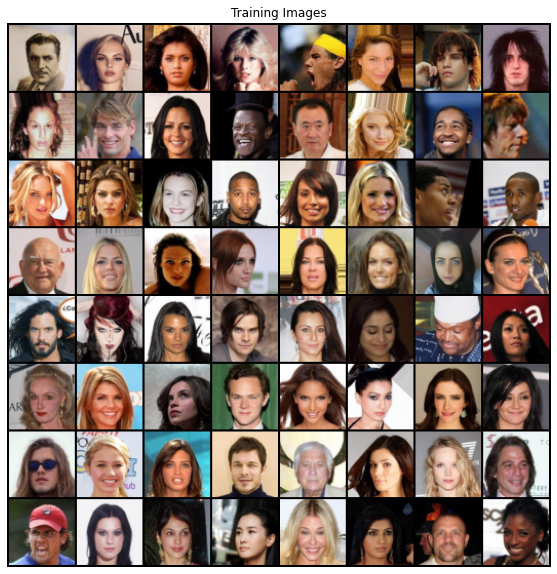

In [ ]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(batch_data[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Defining the Networks
Defining the Self Attention layer , Generator and the Discriminator Networks, Self Attention has been designed as per the concept introduced in Vaswani et.al's paper "Attention is All You Need" and Zhnang et.al's paper "Self Attention Generative Adversarial Networks"

In [ ]:
class SelfAttention(nn.Module):
  def __init__(self, ngpu, in_dim):
    super(SelfAttention, self).__init__()
    self.ngpu = ngpu # Here I am specifying the gpu for storage purposes and better matrix multiplication
    self.fx = nn.Conv2d(in_channels=in_dim, out_channels=in_dim//2, kernel_size=1)
    self.gx = nn.Conv2d(in_channels= in_dim, out_channels= in_dim//2, kernel_size=1)
    self.hx = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
    self.gamma = nn.Parameter(torch.zeros(1)) # Creates a trainable parameter
    self.softmax = nn.Softmax(dim = -1)
  
  def forward(self, x):
    m_batch_size, C, width, height = x.size() # Returns a list , the first one contains the Batch_size, C  = No.of channels, Width and height
    fx = self.fx(x).view(m_batch_size, -1, width*height).permute(0,2,1) # transpose the output of the previous layer matrix acording to definition, basically a vector is created by using view (x)
    gx = self.gx(x).view(m_batch_size, -1, width*height)
    hx = self.hx(x).view(m_batch_size, -1, width * height)
    product = torch.bmm(fx, gx) # Basically a dot product is calculated between the resultant tensors
    attention_map = self.softmax(product) # B *N * N
    out = torch.bmm(hx, attention_map.permute(0,2,1)) # Returns tensor of dimensions B*C*N
    out = out.view(batch_size,C, width, height) # Returns Tensor of dimension B * C * W * H
    y = self.gamma * out +x
    y = y.view(m_batch_size, -1, width , height)
    return y

In [ ]:
class Generator(nn.Module):
  def __init__(self, ngf, nz, no_of_channels):
    super(Generator, self).__init__()
    self.generator = nn.Sequential(
                        nn.ConvTranspose2d(in_channels= nz,out_channels= ngf * 8, kernel_size=4, stride= 1, padding = 0),
                        nn.BatchNorm2d(ngf * 8),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=ngf * 8, out_channels= ngf * 4, kernel_size=4, stride = 2, padding = 1),
                        nn.BatchNorm2d(ngf*4),
                        nn.ReLU(),
                        nn.ConvTranspose2d(in_channels=ngf * 4, out_channels= ngf * 2, kernel_size=4, stride=2,padding=1),
                        nn.BatchNorm2d(ngf * 2),
                        nn.ReLU(),
                        SelfAttention(ngpu, in_dim = ngf * 2),
                        nn.ConvTranspose2d(in_channels=ngf * 2, out_channels= ngf , kernel_size=4, stride=2,padding=1),
                        nn.BatchNorm2d(ngf),
                        nn.ReLU(),
                        SelfAttention(ngpu, in_dim = ngf),
                        nn.ConvTranspose2d(in_channels=ngf , out_channels= no_of_channels, kernel_size=4, stride=2,padding=1),
                        #nn.BatchNorm2d(no_of_channels),
                        nn.Tanh()                    
                        )
  def forward(self,input):
      return self.generator(input)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self, ndf, ngpu, no_of_channels):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.discriminator = nn.Sequential(
                            spectral_norm(nn.Conv2d(in_channels=no_of_channels, out_channels= ndf, kernel_size=4, stride = 2, padding = 1)),
                            nn.BatchNorm2d(ndf),
                            nn.LeakyReLU(0.1),
                            spectral_norm(nn.Conv2d(in_channels=ndf, out_channels= ndf * 2, kernel_size=4,stride = 2, padding = 1 )),
                            nn.BatchNorm2d(ndf * 2),
                            nn.LeakyReLU(0.1),
                            spectral_norm(nn.Conv2d(in_channels=ndf * 2, out_channels= ndf * 4, kernel_size= 4, stride=  2, padding = 1)),
                            nn.BatchNorm2d(ndf * 4),
                            nn.LeakyReLU(0.1),
                            SelfAttention(ngpu, ndf * 4),
                            spectral_norm(nn.Conv2d(in_channels = ndf * 4, out_channels = ndf * 8, kernel_size = 4, stride = 2, padding = 1)),
                            nn.BatchNorm2d(ndf * 8),
                            nn.LeakyReLU(0.1),
                            SelfAttention(ngpu, in_dim = ndf * 8),
                            nn.Conv2d(in_channels= ndf * 8, out_channels = 1, kernel_size= 4, stride= 2, padding= 0),
                            #nn.BatchNorm2d(1),
                            
                          )
  def forward(self, input):
      out = self.discriminator(input)
      return out.squeeze()

In [ ]:
netGenerator = Generator(ngf, nz, no_of_channels).to(device)

In [ ]:
netDiscriminator = Discriminator(ndf, ngpu, no_of_channels).to(device)

In [ ]:
print(netGenerator)

Generator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): SelfAttention(
      (fx): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (gx): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
      (hx): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (10): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [ ]:
print(netDiscriminator)

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.1)
    (9): SelfAttention(
      (fx): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (gx): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
      (hx): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (softmax): Softmax(dim=-1)
    )
    (10): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (11)

## Defining the training Loop

In [ ]:
epochs = 1000
beta1 = 0
learning_rate_D = 0.0004
learning_rate_G = 0.0001

In [ ]:
real_label, fake_label = 1, 0

In [ ]:
def denorm(t):
  t = t.mul(0.5).add(0.5)
  t = t.clamp(0,1)
  return t

In [ ]:
def train(netDiscriminator, netGenerator, epoch, epochs, optimizerD, optimizerG, loss_Discriminator, loss_Generator):
  #iters = 0
  PATH_TO_FAKE = '/content/gdrive/My Drive/Fake Images/'
  for epoch in range(epoch,epochs):
    for i, data in enumerate(dataloader,0):
      # Train Discriminator
      batch_data = data[0].to(device)
      b_size = batch_data.size(0)
      #label = torch.full(real_label, b_size, device = device)
      #print(batch_data.size())
      output_real = netDiscriminator(batch_data).view(-1) # Reshapes to a 128 sized tensor
      err_Discriminator_real = nn.ReLU()(1.0 - output_real).mean()
      noise = torch.randn(b_size, nz, 1, 1, device = device)
      fake_images = netGenerator(noise)
      output_fake = netDiscriminator(fake_images)
      errDiscrimator_fake = nn.ReLU()(1.0 + output_fake).mean()
      total_loss = err_Discriminator_real+errDiscrimator_fake
      netDiscriminator.zero_grad()
      netGenerator.zero_grad()
      total_loss.backward()
      optimizerD.step()
      #Train Generator
      #if epoch % 5 == 0:
      noise = torch.randn(b_size, nz, 1, 1, device = device)
      fake_images = netGenerator(noise)
      fake_outputs = netDiscriminator(fake_images)
      loss_Generator_fake = -fake_outputs.mean()
      netDiscriminator.zero_grad()
      netGenerator.zero_grad()
      loss_Generator_fake.backward()
      optimizerG.step()
      if(i%50 == 0):
        print('epoch', epoch,'Discrimator Loss', total_loss.item(), 'Generator Loss', loss_Generator_fake.item())
      loss_Discriminator.append(total_loss.item())
      loss_Generator.append(loss_Generator_fake.item())
      #Saving Model after every 100th epoch
      if (epoch % 100) == 0:
        checkpoint_discriminator = {
            'epoch' : epoch ,
            'discriminator_model_state_dict':netDiscriminator.state_dict(),
            'optimizer_discriminator_state_dict':optimizerD.state_dict(),
            'loss':loss_Discriminator
            }
        torch.save(checkpoint_discriminator,Discriminator_path)
        checkpoint_generator = {
            'epoch' : epoch ,
            'generator_model_state_dict':netGenerator.state_dict(),
            'optimizer_generator_state_dict':optimizerG.state_dict(),
            'loss':loss_Generator
            }
        torch.save(checkpoint_generator, Generator_path)
      if (epoch % 100 == 0) or ((epoch == epochs - 1) and (i == len(dataloader)-1)):
        fake = netGenerator(fixed_noise)
        path_to_save = os.path.join(PATH_TO_FAKE, 'Generator2_Epoch{}'.format(epoch))
        if os.path.exists(path_to_save):
          #print('inside if')
          for i in range(fake.size()[0]):
            vutils.save_image(denorm(fake[i, :, :, :]),os.path.join(path_to_save,'{}_fake.png'.format(i)))
        else:
         #print('inside else')
          os.mkdir(path_to_save)
          for i in range(fake.size()[0]):
            vutils.save_image(denorm(fake[i, :, :, :]),os.path.join(path_to_save,'{}_fake.png'.format(i)))
        #print(fake.size())
        #Saving for visualization purposes
        vutils.save_image(denorm(fake), os.path.join(PATH_TO_FAKE,'{}_fake_Generator2.png'.format(epoch)))
        #img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

      #iters += 1

In [ ]:
#loss = nn.BCELoss()
fixed_noise = torch.randn(batch_size, nz, 1,1, device= device)
optimizerD = optim.Adam(netDiscriminator.parameters(), lr = learning_rate_D, betas =  (beta1, 0.9))
optimizerG = optim.Adam(netGenerator.parameters(), lr = learning_rate_G, betas = (beta1, 0.9))
loss_Discriminator = []
loss_Generator = []
iters = 0
#img_list = []
Discriminator_path = '/content/gdrive/My Drive/SAGAN Models/Discriminator_with_spectral_norm.pt'
Generator_path = '/content/gdrive/My Drive/SAGAN Models/Generator_without_spectral_norm_1.pt'

In [ ]:
train(netDiscriminator, netGenerator, 0, epochs, optimizerD, optimizerG,loss_Discriminator, loss_Generator)

epoch 0 Discrimator Loss 1.9527742862701416 Generator Loss 3.388151168823242
epoch 0 Discrimator Loss 0.17626804113388062 Generator Loss 11.656593322753906
epoch 0 Discrimator Loss 0.17397436499595642 Generator Loss 13.62734603881836
epoch 0 Discrimator Loss 0.011377592571079731 Generator Loss 4.803966522216797
epoch 0 Discrimator Loss 0.0 Generator Loss 4.7627387046813965
epoch 0 Discrimator Loss 0.011040854267776012 Generator Loss 4.280657768249512
epoch 0 Discrimator Loss 0.0 Generator Loss 7.686194896697998
epoch 0 Discrimator Loss 1.0676615238189697 Generator Loss 1.549288272857666
epoch 0 Discrimator Loss 2.6193017959594727 Generator Loss 7.2860918045043945
epoch 0 Discrimator Loss 0.8357774019241333 Generator Loss 6.489665985107422
epoch 0 Discrimator Loss 3.9817402362823486 Generator Loss 9.07431697845459
epoch 0 Discrimator Loss 0.03748496621847153 Generator Loss 3.940443277359009
epoch 0 Discrimator Loss 2.0357532501220703 Generator Loss 10.852192878723145
epoch 0 Discrimator

KeyboardInterrupt: ignored

In [ ]:
Discriminator_checkpoint = torch.load(Discriminator_path)
Generator_checkpoint = torch.load(Generator_path)

In [ ]:
netDiscriminator.load_state_dict(Discriminator_checkpoint['discriminator_model_state_dict'])
optimizerD.load_state_dict(Discriminator_checkpoint['optimizer_discriminator_state_dict'])
netGenerator.load_state_dict(Generator_checkpoint['generator_model_state_dict'])
optimizerG.load_state_dict(Generator_checkpoint['optimizer_generator_state_dict'])
loss_Discriminator = Discriminator_checkpoint['loss']
loss_Generator = Generator_checkpoint['loss']

In [ ]:
epoch = Discriminator_checkpoint['epoch']

In [ ]:
epoch

600

In [ ]:
train(netDiscriminator,netGenerator, epoch, epochs, optimizerD, optimizerG, loss_Discriminator, loss_Generator )

epoch 500 Discrimator Loss 0.6539262533187866 Generator Loss 28.961828231811523
epoch 500 Discrimator Loss 0.0 Generator Loss 29.50566864013672
epoch 500 Discrimator Loss 1.252655029296875 Generator Loss 46.416473388671875
epoch 500 Discrimator Loss 0.1662030667066574 Generator Loss 22.67184829711914
epoch 500 Discrimator Loss 0.4985208809375763 Generator Loss 29.390792846679688
epoch 500 Discrimator Loss 0.0 Generator Loss 28.841861724853516
epoch 500 Discrimator Loss 0.06249898299574852 Generator Loss 15.003968238830566
epoch 500 Discrimator Loss 0.0 Generator Loss 27.754478454589844
epoch 500 Discrimator Loss 0.0 Generator Loss 30.372360229492188
epoch 500 Discrimator Loss 0.20896843075752258 Generator Loss 33.97685241699219
epoch 500 Discrimator Loss 0.0 Generator Loss 26.21717071533203
epoch 500 Discrimator Loss 0.4590691328048706 Generator Loss 21.229644775390625
epoch 500 Discrimator Loss 0.2609589695930481 Generator Loss 21.514646530151367
epoch 500 Discrimator Loss 0.0 Generat

In [ ]:
epoch_set = np.linspace(1,500, num = 500, dtype = 'int')

In [ ]:
69312 / 64

1083.0

In [ ]:
loss_G = []
for i in range(0,len(loss_Generator),1083):
  loss_G.append(np.mean(loss_Generator[i:i+1083]))

In [ ]:
loss_G = loss_G[0:500]

In [ ]:
loss_D = []
for i in range(0,len(loss_Discriminator),1083):
  loss_D.append(np.mean(loss_Discriminator[i:i+1083]))

In [ ]:
loss_D = loss_D[0:500]

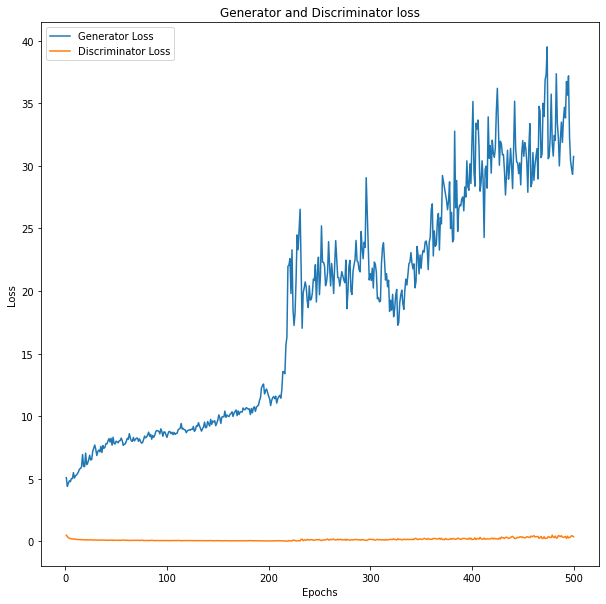

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(epoch_set, loss_G, label = 'Generator Loss')
plt.plot(epoch_set, loss_D, label = 'Discriminator Loss')
plt.title('Generator and Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()